In [1]:
include("../scripts/robot.jl")

In [2]:
using Distributions
using LinearAlgebra
using StatsBase

In [4]:
mutable struct Particle
    pose
    weight
end

In [5]:
function motion_update(self::Particle, nu, omega, time, noise_rate_pdf)
    ns = rand(noise_rate_pdf)
    noised_nu = nu + ns[1]*sqrt(abs(nu)/time) + ns[2]*sqrt(abs(omega)/time)
    noised_omega = omega + ns[3]*sqrt(abs(nu)/time) + ns[4]*sqrt(abs(omega)/time)
    self.pose = state_transition(IdealRobot([]), noised_nu, noised_omega, time, self.pose)
end

motion_update (generic function with 1 method)

In [6]:
function observation_update(self::Particle, observation, envmap, distance_dev_rate, direction_dev)
#     print(observation)
    for d in observation
        obs_pos = d[1]
        obs_id = d[2]+1#1-indexed in julia
        
        pos_on_map = envmap.landmarks[obs_id].pos
        particle_suggest_pos = relative_polar_pos(IdealCamera(), self.pose, pos_on_map)
        
        distance_dev = distance_dev_rate*particle_suggest_pos[1]
        cov = Diagonal([distance_dev^2, direction_dev^2])
        self.weight *= pdf(MvNormal(particle_suggest_pos, cov), obs_pos)
    end
end

observation_update (generic function with 1 method)

In [7]:
mutable struct Mcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
end

In [8]:
function Mcl_(envmap, init_pose, num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
                        distance_dev_rate=0.14, direction_dev=0.05)
    self = Mcl(ntuple(x->nothing, fieldcount(Mcl))...)
    self.particles =[Particle(init_pose, 1.0/num) for i in 1:num-1]
    self.map = envmap
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    return self
end

Mcl_ (generic function with 4 methods)

In [9]:
function motion_update(self::Mcl, nu, omega, time)
    for p in self.particles
        motion_update(p, nu, omega, time, self.motion_noise_rate_pdf)
    end
end

motion_update (generic function with 2 methods)

In [10]:
function observation_update(self::Mcl, observation)
    for p in self.particles
        observation_update(p, observation, self.map, self.distance_dev_rate, self.direction_dev)
    end
    resampling(self)
end

observation_update (generic function with 2 methods)

In [17]:
rand(Uniform(0,10))

9.258608972566222

In [28]:
x = []
append!(x, 1)

1-element Array{Any,1}:
 1

In [37]:
function resampling(self::Mcl)
    ws = cumsum([e.weight for e in self.particles])
    if ws[end] < 1e-100
        ws = [e+1e-100 for e in ws]
    end
    step = ws[end]/length(self.particles)
    r = rand(Uniform(0.0, step))
    cur_pos = 1
    ps = []
    while (length(ps) < length(self.particles))
        if r < ws[cur_pos]
            push!(ps, self.particles[cur_pos])
            r += step
        else
            cur_pos += 1
#             if cur_pos > length(self.particles)
#                 cur_pos = 1
#             end
        end
        
    end
    self.particles = [deepcopy(e) for e in ps]
    for p in self.particles
        p.weight = 1.0/length(self.particles)
    end
end

resampling (generic function with 1 method)

In [38]:
function draw(self::Mcl, ax, elems)
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, angles="xy", scale_units="xy", color="blue", alpha=0.5))
end

draw (generic function with 7 methods)

In [39]:
mutable struct EstimationAgent <: AbstractAgent
    nu
    omega
    estimator
    time_interval
    prev_nu
    prev_omega
end

In [40]:
function  EstimationAgent_(time_interval, nu, omega,estimator)
    self = EstimationAgent(ntuple(x->nothing, fieldcount(EstimationAgent))...)
    self.nu = nu
    self.omega = omega
    self.estimator = estimator
    self.time_interval = time_interval
    self.prev_nu = 0.0
    self.prev_omega = 0.0
    return self
end

EstimationAgent_ (generic function with 1 method)

In [41]:
function decision(self::EstimationAgent, observation=nothing)
    motion_update(self.estimator, self.prev_nu, self.prev_omega, self.time_interval)
    self.prev_nu, self.prev_omega = self.nu, self.omega
    observation_update(self.estimator,observation)
    return self.nu, self.omega
end

decision (generic function with 4 methods)

In [42]:
function draw(self::EstimationAgent, ax, elems)
    draw(self.estimator, ax, elems)
end

draw (generic function with 7 methods)

In [43]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    estimator = Mcl_(m, initial_pose, 100)
    a = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, estimator)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAl+NtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAF8ZliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5GeJI+w65vIpFM505Ok+93xmUtuVHGQ3eacRH3D3LWgvRa8VlJf0rW/lw3pNMKrLBfC42qBBbPPf9t2q9s/FQBF+eHBqb/CB1m4Za8y+nnzp4tqwGv7FWpgi0iuEQ4W59KBcdz8U2ukqDc8XRyHIGUzQWrN2B2hH41jBxiu8GM2/yYQASZZNk6cnN992hxnRVU/+oJK/JdfpqQC09Qp+0lkF/MADsjxgxnmkyiD4cJFbjyc/bIvgLZswUinp9mbC+OqS+B3Ka9nIBrRd8URZmZnmnn6jGyox4iNCMwrJzVTMejzVjwcpF5gWSDBAd3fPNh4CYMsOqHHJJ1HIr3/3KzKyJnKGIPwD1EjEsKeZY5DEKBN4Lbx26JgmuTA0OP3RbWAeL+ir6AAi/ximafLajEKNv7Lw0M8qwpqegzxubJ5ksq1o1ak8MWo5ExiAutL+4sa6ducW9LnJ/HlRhQS/uDuAYZOie2h0NC0fSCAkvoQWQN2jx/piWEhGDjKonuFFNQNTfjAsPC4vY5oRadFNo9n0iTGUw7IJjI2GasaLU9Iv4b+aS7XCO/w2axSSs4uW0UobWYPDfUuyT8lg4T1MK+fgaeXWTf8GHSxwkrUXyj+yRF2f1SlbZCp5L4wJtp1vzNinYOH1y7sx2ItUCiacLeDeqtTRT3uOTjuYN66Gd4QboZuOQ81wbYUxzzGqzlA31uC4KmnGmm1PpSMOitCmn5f6Ri0OUuMVHx6SMQMXd3b6PsHdMPVLFli8hkqnug4H0giKW2AOphJjw8iXVsrR1QmZToEKMzBgi55QRxvIuX8GafEZVUAyUFb+gUGq3q8TvGgUUu0C81J1mLZpmuHfUUVOFfqN4WoHXB042ULYQr2Fb18M72CHc2b7dqCR5lhd6y0fA9GywyqB5C2TXwWUTAvIzyuESNv7NaG9a9EiYEPs3Tl48lsiEhUfQ5LyQD4QqLa66GS4stohiRfibYl/K3tNX7fPvbKdQQjAhlPBggAsOzdFa2N/yhFIpThgLid3cG/GZbpwZEuIpq2WgW90gItjdOfjAZE3e/TCb6eTS2ix8fYOVqleCfMEnreWMf8EkPkJI4Ey/r3SGVKXlvffuS7GTm3nuYH5Y+BVWl/2xjkqZ2ClUrrXyOBONFD6VAMS5O5HaenJSk61AdQCCKA6plloEn2vLtxKQJumSEnzQXVlD9ybr2L9EdbK1S5G+Ni4Xv7z1SRTYYYAYHR5cN8u6gP3nFRMKeCQgyWA+xQLctbI09TWc97Kkhg5n2sa3I5dg4ZvozGZ8gGQJbKNPdCeFzY8D2/TOIijqV+S+3jF+Tvrz4ZsBlhgBbFplCfc4f7jIcGN1PLRXiwDh8xHkczgCOFJA47Ma6DWJ5jVFpffEJC2LaVmAv0L9JPTmBV15BDHeFA5w9q3vvBs8cHMoEhTbNbULDEsoGvdkmVFT0itWsU6aSS9BF12PkttHIJ7ZpvEm4hfnRJ//v33OZfByS17obL3s0d15R4RI4byZSRBgDmNURdJYan4hefxmNrjgK0Z7YmmvF2KyDvKoGa+7Aik3ZGWWuqIBUEzly5DuBPIJNuqLOXrD+pbMps3HcxKGbZ4Na2IyFxNAldeJFYDy2tPa1ZYkZBdy9L8wP53Ex2P5S3NlJKmJyUfJM+atlf+i6V5E8tBzON+QCeZ2CczZtVwtz0THs2eZEzDEIJN5SDfvdrIVyzDcMXQlmdHs3c0XR71fshA3dQodfDv0JbojNAE+C9/eIgvI8rt3VIXDKTAVPIjYiHh6S42L0uUSjQjzRPN1r2n97pE+AZXqkRBt+LoKZZ3G8DrMvkFqstHnbkQjKvYz92srDt1VLCpnpSY8c8n3vtEuWKi18yro9rmrq0D+hSeH1eYlZJ1Z9z+QQMsTsOzSGlf7QUZcbq02BXuJ1BzNa1/S3B3cQyE4m37uFg5iFE6gXfRf1f8DxmxcaJbkG8V077oJyTjrQADvx3hA8xdHxexk4rWBKEPouYZy/cVLu/IFXhuL/QacyP6UJc/T2kZXMQS4HlhnVeUhdmWNSMiMoVhj8rGZ2u/K+DfIWpBLUbLyzSDEQ8VF5BaVZFPScW6hpTUUarlHEBqHDKXn0LcT/Mtqlzp9UMCeRlXexhOexHiI2wggKU/XmmMBKu34Xf+hLV7VIWQ2wuT+A/M7z9Tsz4boP5X/rZk/llwRf9fZtBFqmE7zPX8d5kuo4x7vBNBDfOASznh4mL5p+8mqwjqJa3HMJDiIiJdRRdfcKfAKmMKd4daKPg0eMY9EAyAkzHUgk9LCeNX9Tb0iB90GC0fGYn+QxklfVZbSCqD0bx/b/cje5YCpwJZClai/wjeLye5Vlv/PZ+JNtOiDnbrlvgE562Z5lv4dxOC2lpQ7NV+TMTBUbbu71ekE92Ypq6vC4LPfo2EcQy

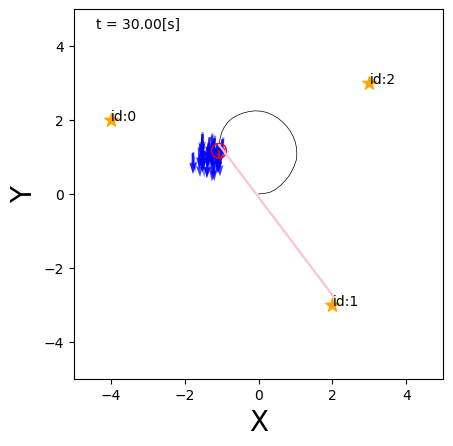

In [44]:
trial()